In [1]:
!pip install --upgrade pip

!pip install --quiet diffusers transformers accelerate torch torchvision torchaudio ftfy
!pip install --quiet git+https://github.com/openai/CLIP.git
!pip install --quiet scipy pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [3]:
# Step 2: 프롬프트 CSV 불러오기

from google.colab import files
uploaded = files.upload()  # → prompt_list.csv 업로드

Saving refined_prompt_list_v1.csv to refined_prompt_list_v1.csv


In [4]:
import pandas as pd

# Load the expanded prompt CSV
df_prompt = pd.read_csv("refined_prompt_list_v1.csv")
df_prompt.head()

prompt_id group_id  group_order   category  \
0      G1_1       G1            1     Simple   
1      G1_2       G1            2   Detailed   
2      G1_3       G1            3  Stylistic   
3      G1_4       G1            4   ArtStyle   
4      G1_5       G1            5   Negative   

                                         prompt_text  has_style  has_negative  \
0                                                fox      False         False   
1                                     a detailed fox      False         False   
2                       a detailed fox in watercolor       True         False   
3     a detailed fox in watercolor in Van Gogh style       True         False   
4  a detailed fox in watercolor in Van Gogh style...      False          True   

   length  
0       1  
1       3  
2       5  
3       9  
4      10

In [5]:
# STEP 3: 모델 로딩 (Stable Diffusion + CLIP)

import torch
from diffusers import StableDiffusionPipeline
import clip
from PIL import Image
import torchvision.transforms as T

# 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# Stable Diffusion 1.4 모델 로딩 (fp16 for VRAM 절약)
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    revision="fp16",
    safety_checker=None
).to(device)
pipe.enable_attention_slicing()

# CLIP 로딩 (OpenAI ViT-B/32)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis-

In [6]:
# STEP 4: 이미지 → latent vector 추출 함수
@torch.no_grad()
def get_latent_from_image(image: Image.Image):
    image_tensor = T.Compose([
        T.Resize((512, 512)),
        T.ToTensor(),
        T.Normalize([0.5], [0.5])
    ])(image).unsqueeze(0).to(device).half()  # float16 for SD compatibility

    with torch.no_grad():
        latent = pipe.vae.encode(image_tensor).latent_dist.sample()
        latent = 0.18215 * latent  # scaling factor used in SD
        return latent.detach().cpu().numpy().flatten()


In [7]:
# STEP 5: 이미지 → CLIP embedding
@torch.no_grad()
def get_clip_similarity(image: Image.Image, text: str):
    image_input = clip_preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([text]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (image_features @ text_features.T).item()

    return similarity

In [8]:
# STEP 5: 이미지 생성 + latent 추출 + CLIP score 저장 루프

import os
from tqdm import tqdm
from PIL import Image
import torch

# Prepare output directory
output_dir = "outputs_same"
image_dir = os.path.join(output_dir, "images")
os.makedirs(image_dir, exist_ok=True)

# Store results
results = []

for _, row in tqdm(df_prompt.iterrows(), total=len(df_prompt)):
    prompt_id = row["prompt_id"]
    prompt_text = row["prompt_text"]

    # Generate image
    with torch.autocast("cuda"):
        result = pipe(prompt_text, guidance_scale=7.5, num_inference_steps=50)
    image = result.images[0]

    # Save image
    image_path = os.path.join(image_dir, f"{prompt_id}.png")
    image.save(image_path)

    # Extract latent vector
    latent_vector = get_latent_from_image(image)

    # Compute CLIP similarity
    clip_score = get_clip_similarity(image, prompt_text)

    # Store
    results.append({
        **row.to_dict(),
        "clip_score": clip_score,
        "latent_vector": latent_vector.tolist(),
        "image_path": image_path
    })

# Create results DataFrame
df_result = pd.DataFrame(results)

# Save results to CSV + Pickle
df_result.to_csv(os.path.join(output_dir, "clip_latent_results.csv"), index=False)
df_result.to_pickle(os.path.join(output_dir, "clip_latent_results.pkl"))

output_dir

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  1%|          | 1/100 [00:15<25:50, 15.67s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:29<24:12, 14.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  3%|▎         | 3/100 [00:44<23:50, 14.74s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  4%|▍         | 4/100 [00:58<23:23, 14.62s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  5%|▌         | 5/100 [01:12<22:48, 14.40s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 6/100 [01:26<22:20, 14.26s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  7%|▋         | 7/100 [01:40<21:56, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  8%|▊         | 8/100 [01:54<21:40, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  9%|▉         | 9/100 [02:09<21:28, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 10%|█         | 10/100 [02:23<21:16, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 11%|█         | 11/100 [02:37<21:01, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [02:51<20:45, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [03:05<20:29, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [03:19<20:14, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [03:33<19:59, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [03:48<19:46, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [04:02<19:33, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [04:16<19:20, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [04:30<19:05, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 20/100 [04:44<18:52, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 21%|██        | 21/100 [04:58<18:38, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [05:13<18:24, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [05:27<18:12, 14.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [05:41<17:57, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [05:55<17:42, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [06:09<17:28, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [06:24<17:14, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [06:38<17:00, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [06:52<16:48, 14.20s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 30%|███       | 30/100 [07:06<16:33, 14.19s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 31%|███       | 31/100 [07:20<16:18, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [07:34<16:02, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [07:49<15:48, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [08:03<15:32, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [08:17<15:18, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [08:31<15:04, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [08:45<14:50, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [08:59<14:35, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [09:13<14:20, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 40%|████      | 40/100 [09:27<14:06, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 41%|████      | 41/100 [09:42<13:53, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [09:56<13:40, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [10:10<13:26, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [10:24<13:12, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [10:38<12:58, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [10:52<12:44, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [11:06<12:30, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [11:21<12:16, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [11:35<12:01, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 50/100 [11:49<11:47, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 51%|█████     | 51/100 [12:03<11:33, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [12:17<11:19, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [12:31<11:06, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [12:46<10:51, 14.17s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [13:00<10:36, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [13:14<10:22, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [13:28<10:08, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [13:42<09:54, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [13:56<09:40, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 60%|██████    | 60/100 [14:10<09:26, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 61%|██████    | 61/100 [14:25<09:12, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [14:39<08:57, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [14:53<08:43, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [15:07<08:29, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [15:21<08:15, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [15:35<08:00, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [15:49<07:46, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [16:04<07:32, 14.14s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [16:18<07:17, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 70%|███████   | 70/100 [16:32<07:03, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 71%|███████   | 71/100 [16:46<06:49, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [17:00<06:35, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [17:14<06:21, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [17:28<06:07, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [17:42<05:52, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [17:57<05:38, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [18:11<05:24, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [18:25<05:10, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [18:39<04:56, 14.12s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 80/100 [18:53<04:41, 14.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 81%|████████  | 81/100 [19:07<04:27, 14.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [19:21<04:14, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [19:35<04:00, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [19:50<03:46, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [20:04<03:32, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [20:18<03:18, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [20:32<03:04, 14.16s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [20:46<02:50, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [21:00<02:35, 14.18s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [21:15<02:21, 14.15s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [21:29<02:07, 14.13s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [21:43<01:52, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [21:57<01:38, 14.11s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [22:11<01:24, 14.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [22:25<01:10, 14.10s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [22:39<00:56, 14.09s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [22:53<00:42, 14.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [23:07<00:28, 14.08s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [23:21<00:14, 14.07s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 100/100 [23:35<00:00, 14.16s/it]


'outputs_same'

In [9]:
!zip -r outputs_same.zip outputs_same

  adding: outputs_same/ (stored 0%)
  adding: outputs_same/images/ (stored 0%)
  adding: outputs_same/images/G3_3.png (deflated 0%)
  adding: outputs_same/images/G18_4.png (deflated 0%)
  adding: outputs_same/images/G18_5.png (deflated 0%)
  adding: outputs_same/images/G10_5.png (deflated 0%)
  adding: outputs_same/images/G17_2.png (deflated 0%)
  adding: outputs_same/images/G11_3.png (deflated 0%)
  adding: outputs_same/images/G5_5.png (deflated 0%)
  adding: outputs_same/images/G1_3.png (deflated 0%)
  adding: outputs_same/images/G16_4.png (deflated 0%)
  adding: outputs_same/images/G8_5.png (deflated 0%)
  adding: outputs_same/images/G14_2.png (deflated 0%)
  adding: outputs_same/images/G10_3.png (deflated 0%)
  adding: outputs_same/images/G17_4.png (deflated 0%)
  adding: outputs_same/images/G11_2.png (deflated 0%)
  adding: outputs_same/images/G19_1.png (deflated 0%)
  adding: outputs_same/images/G13_4.png (deflated 0%)
  adding: outputs_same/images/G8_2.png (deflated 0%)
  adding

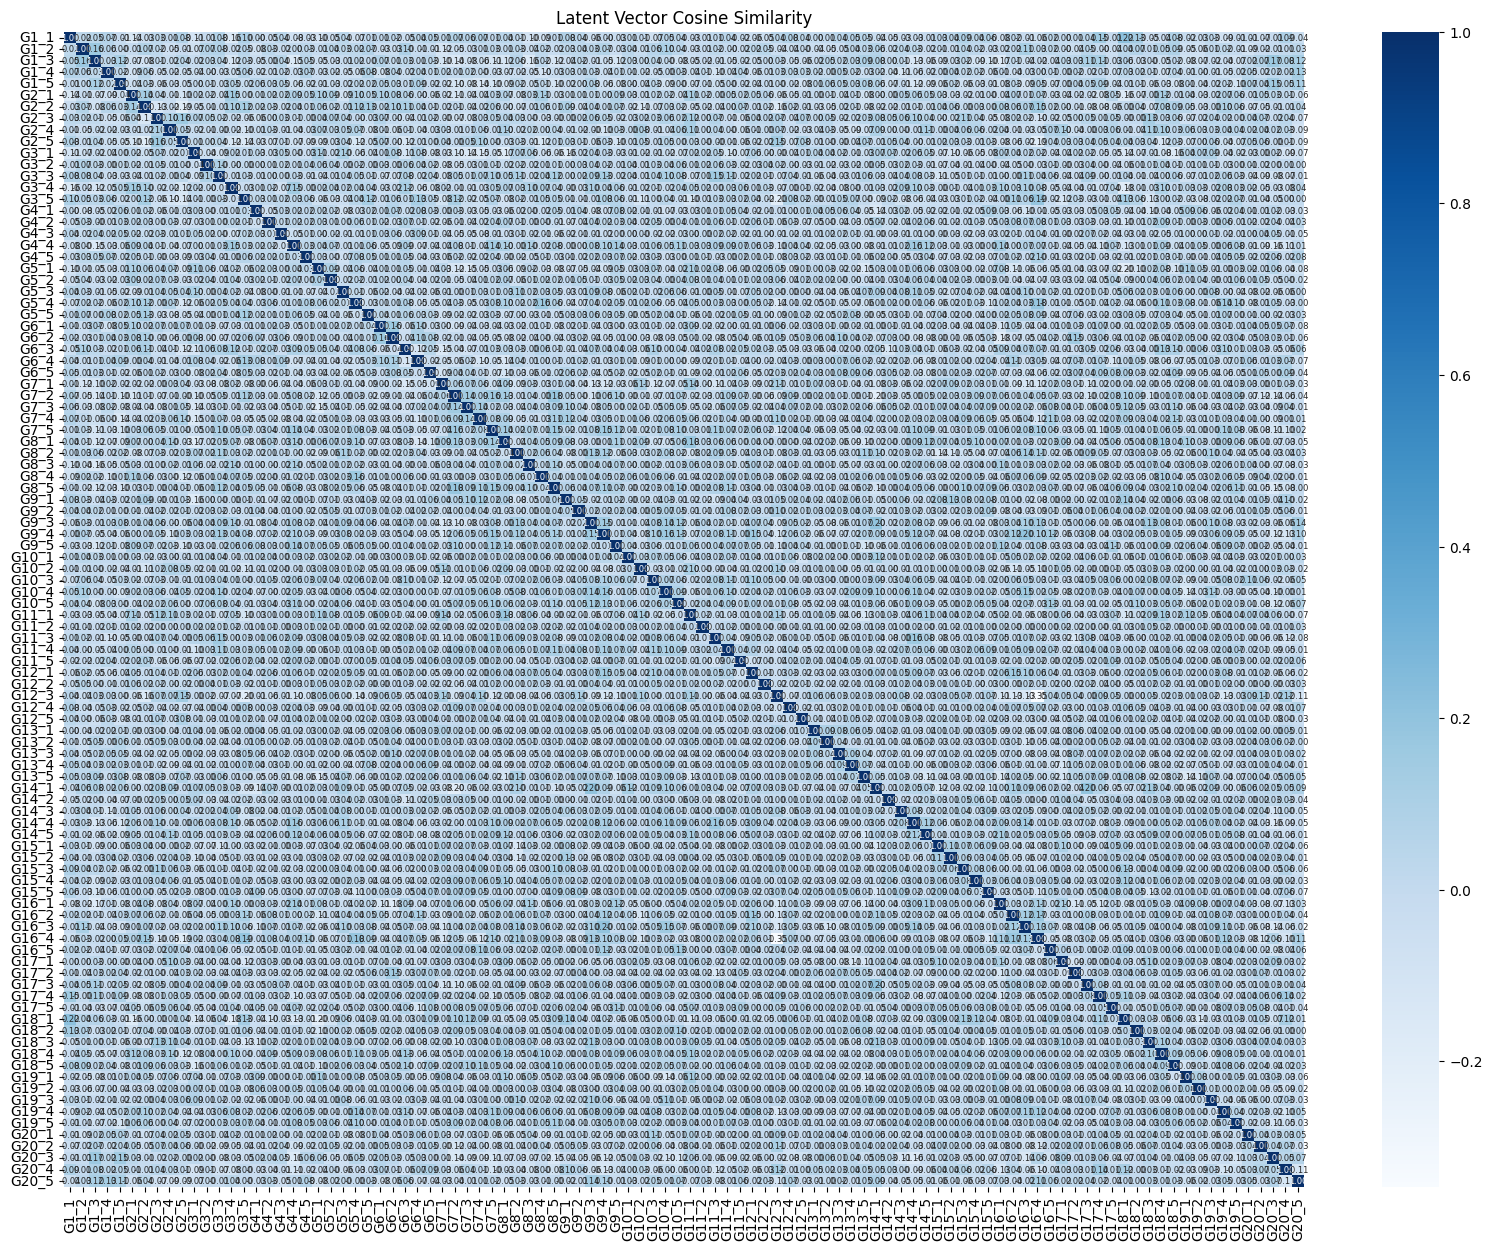

In [10]:
# STEP 7: Latent 간 cosine similarity + 시각화 준비

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# latent vector matrix
latent_matrix = np.stack(df_result["latent_vector"].values)
prompt_ids = df_result["prompt_id"].tolist()

# cosine 유사도 행렬
cos_sim_matrix = cosine_similarity(latent_matrix)

# heatmap 시각화
import seaborn as sns

plt.figure(figsize=(20,15))
sns.heatmap(
    cos_sim_matrix,
    xticklabels=prompt_ids,
    yticklabels=prompt_ids,
    annot=True,
    cmap="Blues",
    fmt=".2f",
    annot_kws={"size": 6}
  )
plt.title("Latent Vector Cosine Similarity")
plt.show()

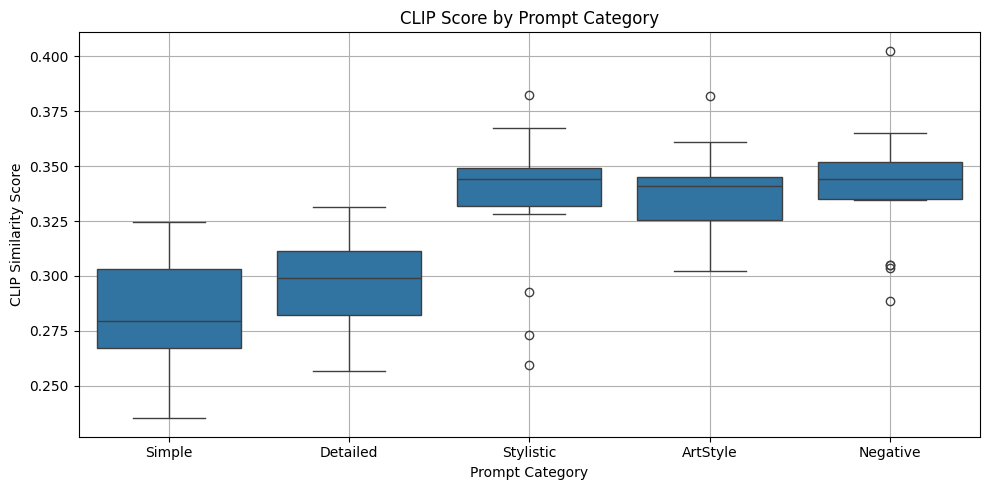

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_result, x="category", y="clip_score")
plt.title("CLIP Score by Prompt Category")
plt.xlabel("Prompt Category")
plt.ylabel("CLIP Similarity Score")
plt.grid(True)
plt.tight_layout()
plt.show()

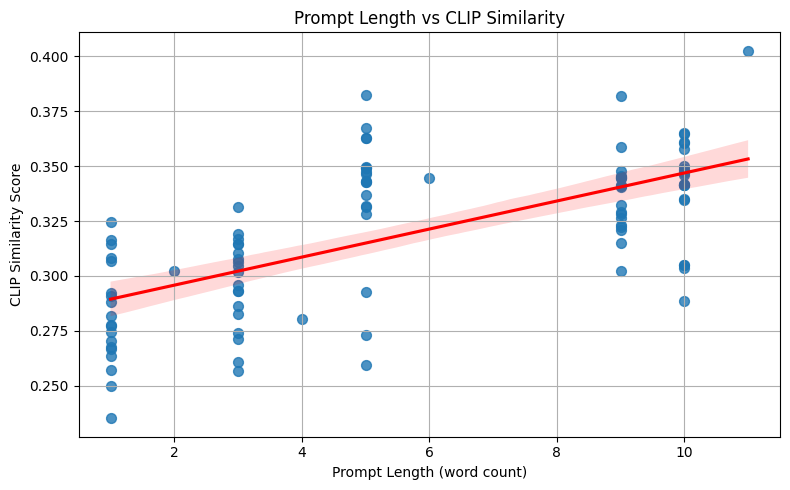

In [12]:
# Prompt length vs CLIP similarity scatter plot
plt.figure(figsize=(8, 5))
sns.regplot(data=df_result, x="length", y="clip_score", scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title("Prompt Length vs CLIP Similarity")
plt.xlabel("Prompt Length (word count)")
plt.ylabel("CLIP Similarity Score")
plt.grid(True)
plt.tight_layout()
plt.show()

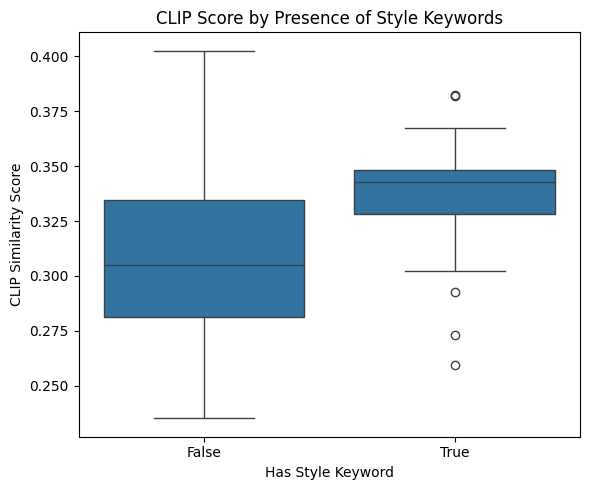

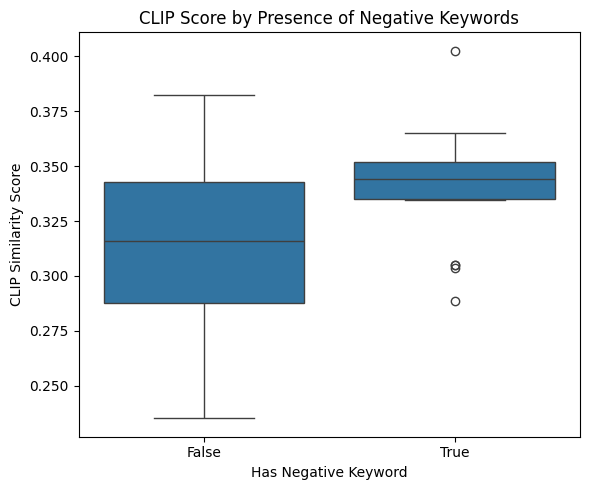

In [13]:
# has_style vs CLIP score
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_result, x="has_style", y="clip_score")
plt.title("CLIP Score by Presence of Style Keywords")
plt.xlabel("Has Style Keyword")
plt.ylabel("CLIP Similarity Score")
plt.tight_layout()
plt.show()

# has_negative vs CLIP score
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_result, x="has_negative", y="clip_score")
plt.title("CLIP Score by Presence of Negative Keywords")
plt.xlabel("Has Negative Keyword")
plt.ylabel("CLIP Similarity Score")
plt.tight_layout()
plt.show()

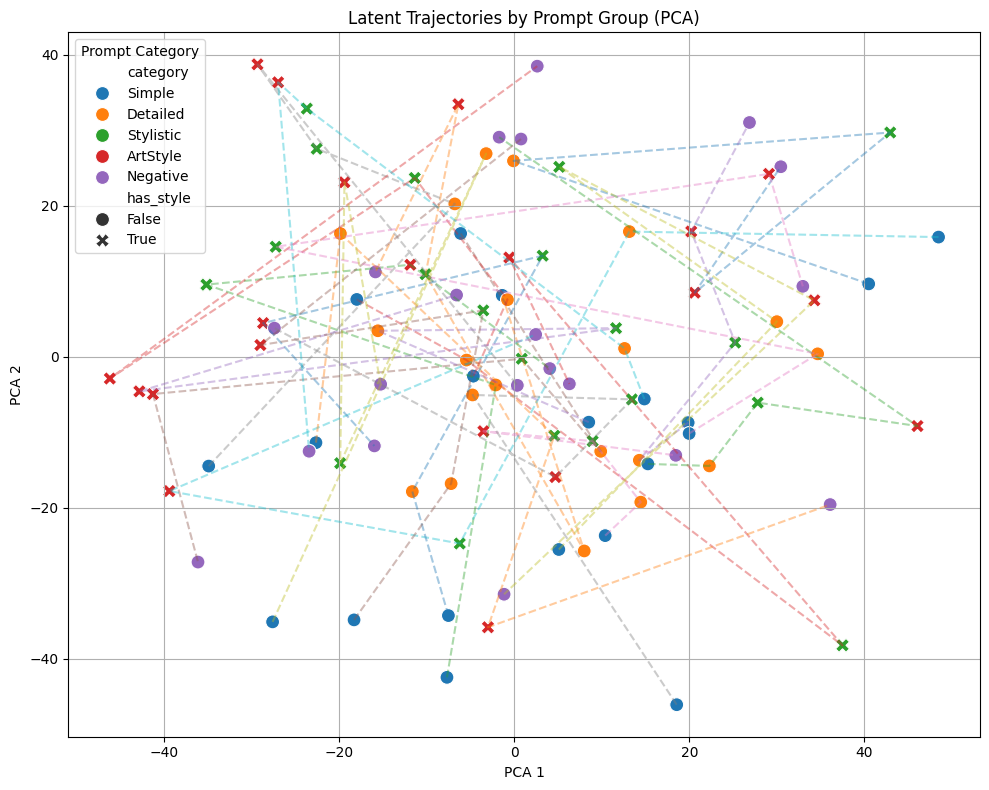

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# group별로 연결선 시각화를 위해 정렬
df_result_sorted = df_result.sort_values(by=["group_id", "group_order"])

# PCA 좌표 다시 준비 (있으면 생략)
from sklearn.decomposition import PCA
latent_matrix = np.stack(df_result_sorted["latent_vector"].values)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_matrix)
df_result_sorted["pca_x"] = pca_result[:, 0]
df_result_sorted["pca_y"] = pca_result[:, 1]

# 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_result_sorted, x="pca_x", y="pca_y", hue="category", style="has_style", s=100)

# group_id별 trajectory 선 연결
for group_id, group_df in df_result_sorted.groupby("group_id"):
    plt.plot(group_df["pca_x"], group_df["pca_y"], linestyle="--", alpha=0.4)

plt.title("Latent Trajectories by Prompt Group (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Prompt Category")
plt.show()

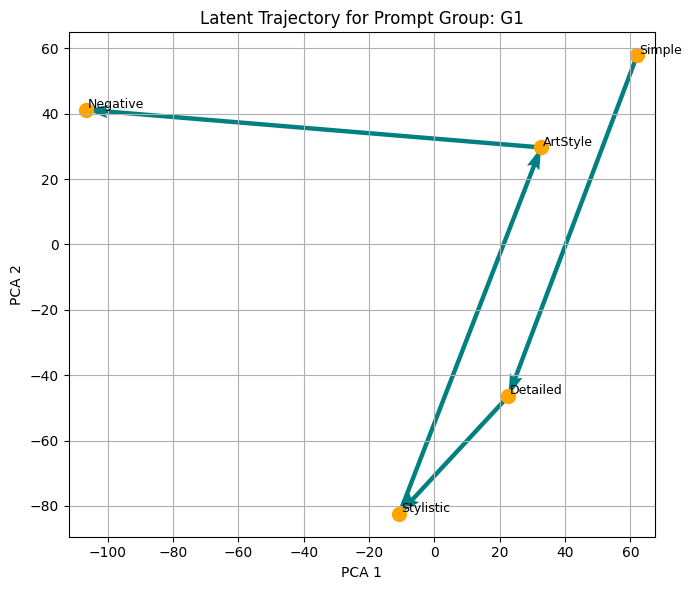

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 특정 그룹 선택 (예: G1)
group_id = "G1"
group_df = df_result[df_result["group_id"] == group_id].sort_values(by="group_order")

# latent matrix 및 PCA
latent_matrix = np.stack(group_df["latent_vector"].values)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_matrix)

# 이동 벡터 계산
X = pca_result[:-1, 0]
Y = pca_result[:-1, 1]
U = pca_result[1:, 0] - X
V = pca_result[1:, 1] - Y

# 시각화
plt.figure(figsize=(7, 6))
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='teal')
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=100, c='orange')

# 포인트마다 라벨 추가
for i, (x, y, text) in enumerate(zip(pca_result[:, 0], pca_result[:, 1], group_df["category"])):
    plt.text(x + 0.5, y + 0.5, text, fontsize=9)

plt.title(f"Latent Trajectory for Prompt Group: {group_id}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

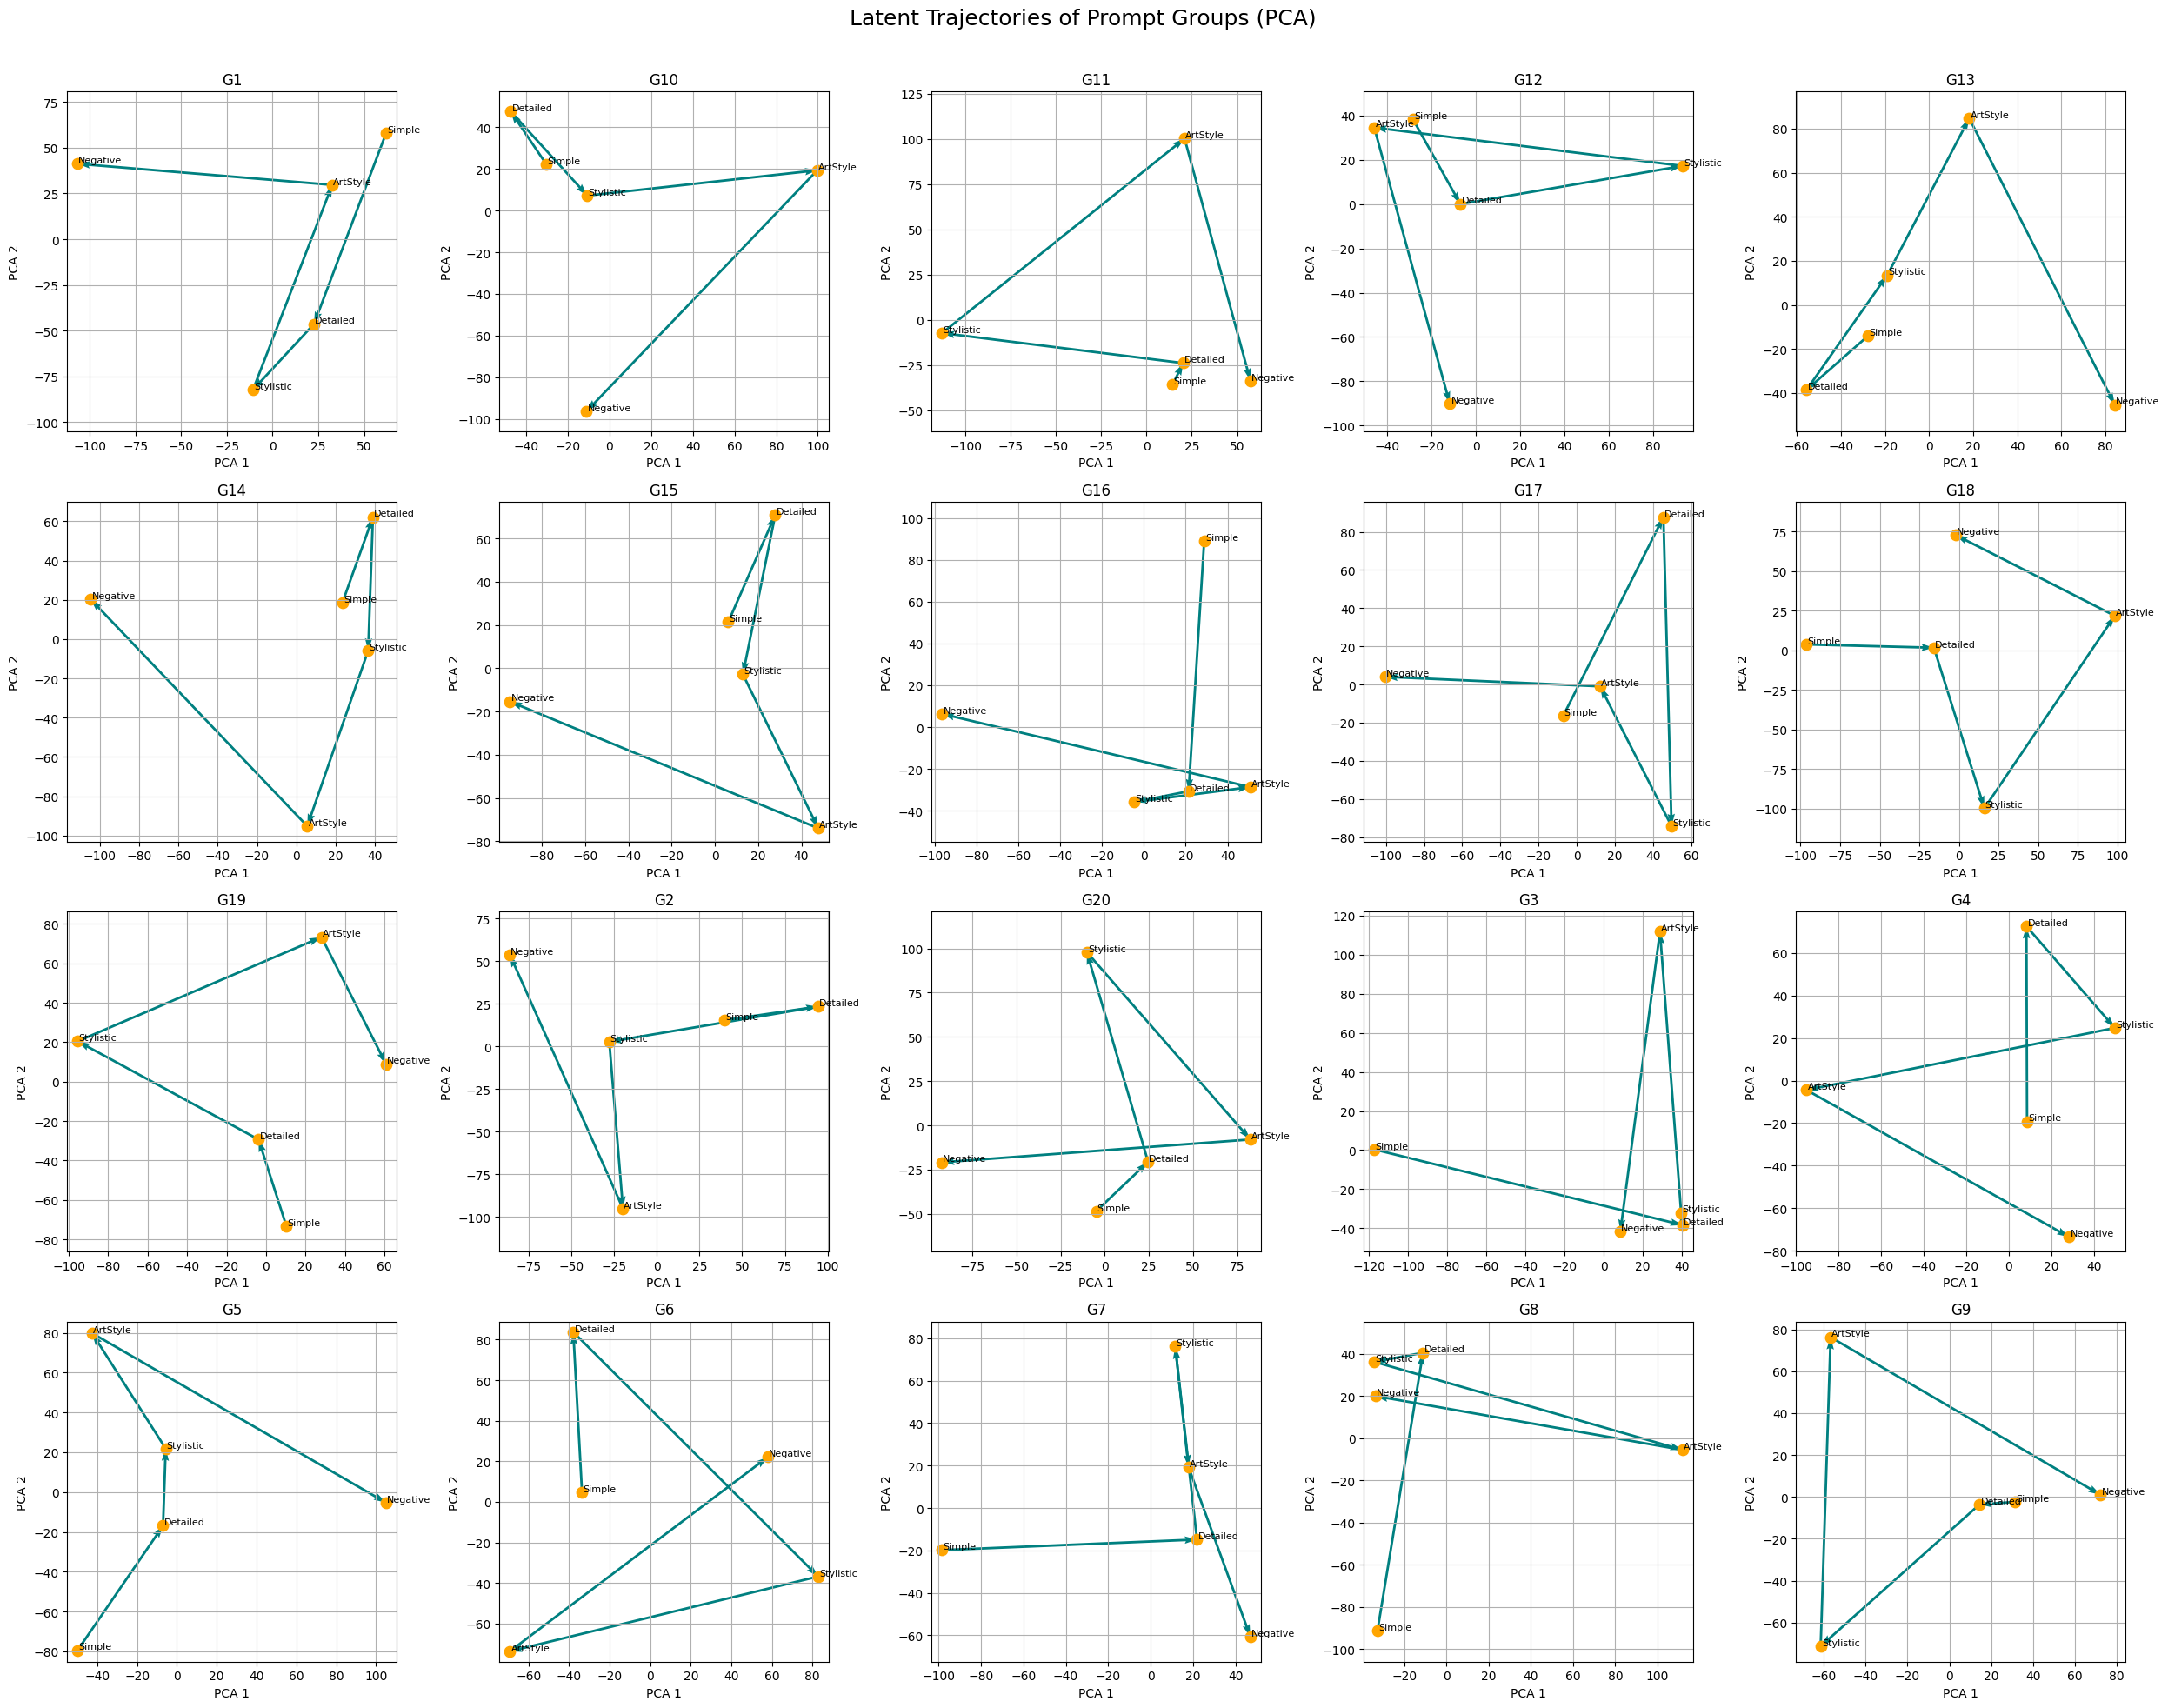

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 전체 figure
fig, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.flatten()

# 각 그룹 반복
for idx, (group_id, group_df) in enumerate(df_result.groupby("group_id")):
    ax = axes[idx]
    group_df = group_df.sort_values(by="group_order")

    latent_matrix = np.stack(group_df["latent_vector"].values)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_matrix)

    X = pca_result[:-1, 0]
    Y = pca_result[:-1, 1]
    U = pca_result[1:, 0] - X
    V = pca_result[1:, 1] - Y

    ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1, color='teal')
    ax.scatter(pca_result[:, 0], pca_result[:, 1], s=80, c='orange')

    for i, (x, y, text) in enumerate(zip(pca_result[:, 0], pca_result[:, 1], group_df["category"])):
        ax.text(x + 0.5, y + 0.5, text, fontsize=8)

    ax.set_title(f"{group_id}", fontsize=12)
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)
    ax.axis("equal")

# 여백 조정
plt.suptitle("Latent Trajectories of Prompt Groups (PCA)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

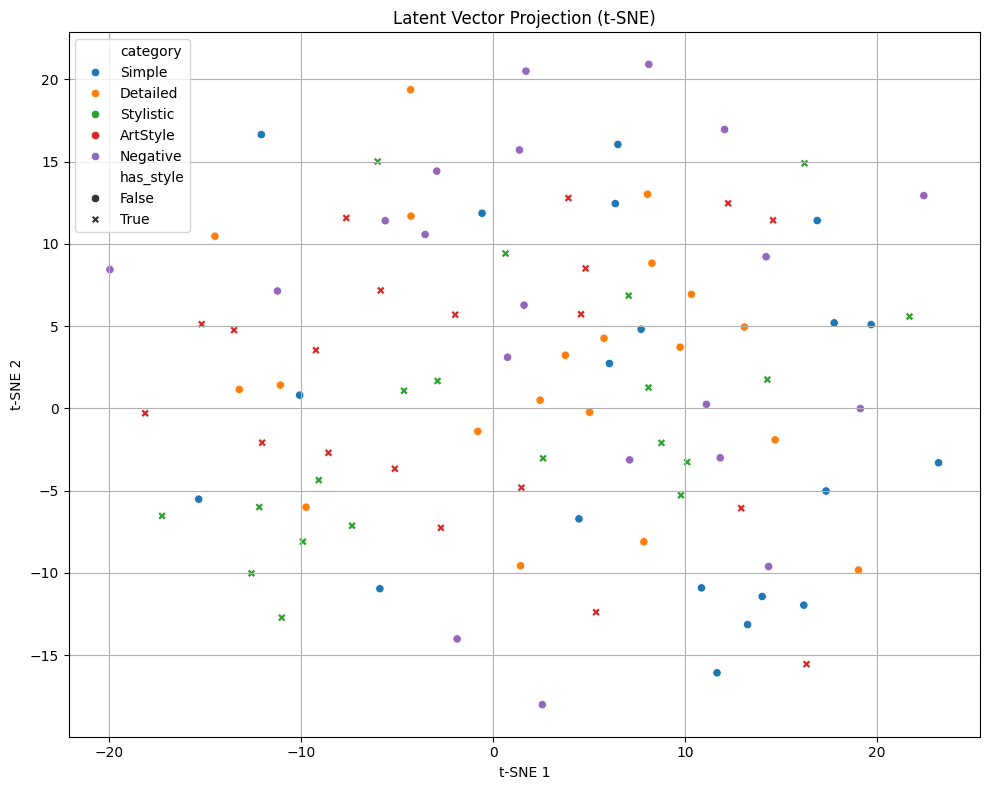

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from itertools import combinations

# t-SNE 투영
latent_matrix = np.stack(df_result["latent_vector"].values)
tsne = TSNE(n_components=2, perplexity=5, init='pca', learning_rate='auto', random_state=42)
tsne_result = tsne.fit_transform(latent_matrix)

# 결과 컬럼 추가
df_result["tsne_x"] = tsne_result[:, 0]
df_result["tsne_y"] = tsne_result[:, 1]

# 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_result, x="tsne_x", y="tsne_y", hue="category", style="has_style")
plt.title("Latent Vector Projection (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

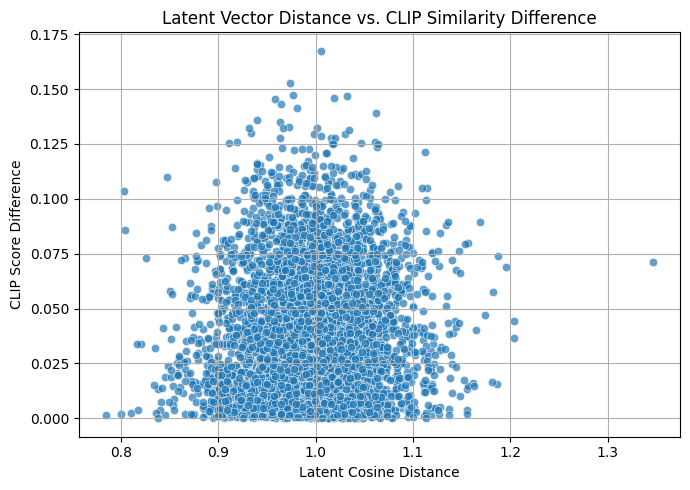

(np.float64(0.05677191150223643), np.float64(6.42933322480225e-05))

In [18]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import pearsonr
import itertools

# 준비: prompt pair 조합 생성
df_result = df_result.sort_values("prompt_id").reset_index(drop=True)
prompt_pairs = list(itertools.combinations(df_result.index, 2))

# 거리와 점수 차이 저장
records = []

for i, j in prompt_pairs:
    pid_i, pid_j = df_result.loc[i, "prompt_id"], df_result.loc[j, "prompt_id"]

    latent_i = df_result.loc[i, "latent_vector"]
    latent_j = df_result.loc[j, "latent_vector"]
    dist_latent = cosine_distances([latent_i], [latent_j])[0][0]

    clip_i = df_result.loc[i, "clip_score"]
    clip_j = df_result.loc[j, "clip_score"]
    diff_clip = abs(clip_i - clip_j)

    records.append({
        "prompt_id_1": pid_i,
        "prompt_id_2": pid_j,
        "latent_distance": dist_latent,
        "clip_diff": diff_clip
    })

df_corr = pd.DataFrame(records)

# 산점도 시각화
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_corr, x="latent_distance", y="clip_diff", alpha=0.7)
plt.title("Latent Vector Distance vs. CLIP Similarity Difference")
plt.xlabel("Latent Cosine Distance")
plt.ylabel("CLIP Score Difference")
plt.grid(True)
plt.tight_layout()
plt.show()

# 상관계수 계산
corr_coef, p_value = pearsonr(df_corr["latent_distance"], df_corr["clip_diff"])
corr_coef, p_value